In [2]:
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.ticker as plticker
from matplotlib.colors import LinearSegmentedColormap
import yaml

In [3]:
# Experimental parameters

# read input data from Init yaml file

with open("Init.yaml", "r") as file:


    Init = yaml.safe_load(file)


rho_oil = Init["oil_density"]  # oil density


D0 = Init["nozzle_diameter"]  # nozzle diameter (m)


V0 = Init["release_vel"]  # release vertical velocity (m s^-1)


dyn_visc_oil = 0.0093479  # dynamic viscosity [N m^-2 s]


kin_visc_oil = dyn_visc_oil / rho_oil


N_particles = 2500  # number of parcels


rho_a = 1029.0  # water density at release point


interf_tens = 0.019  # Interfacial oil water tension (N/m)

In [4]:
# Empirical parameters

r = 14.05
p = 0.46
q = -0.518

In [5]:
# Maximum Characteristic Parcel Diameter d0

d_RT = (
    4 * (interf_tens / ((rho_a - rho_oil) * 9.81)) ** 0.5
)  # Rayleigh - Taylor instability maximum diameter (Li et al,. 2017; Grace et al., 1978)

d0 = min(d_RT, D0)  # minimum between nozzle diameter and d_RT
print("Rayleigh_Taylor diameter:", d_RT)
print("Characteristic MAX diameter:", d0)

Rayleigh_Taylor diameter: 0.014985206945152804
Characteristic MAX diameter: 0.014985206945152804


In [6]:
# Dimensionless characteristic numbers: Weber and Ohnesorge number


We = rho_a * V0**2 * d0 / interf_tens

Oh = dyn_visc_oil / ((rho_oil * interf_tens * d0) ** 0.5)

In [7]:
# Parcel Median Diameter


d50 = (r * (1 + 10 * Oh) ** p) * (We**q) * d0  # (m)


print("median diameter d50", d50)

median diameter d50 0.003455036763939032


In [16]:
Nbins = 200
delta = d0 / Nbins  # equal size ranges bewtween 0 and d0

d = np.zeros(Nbins)
bins = np.zeros(Nbins + 1)
f = np.zeros(Nbins)
f_abs = np.zeros(Nbins)
cum = np.zeros(Nbins)
w = np.zeros(Nbins)

ln_sigma = 0.5

In [17]:
# Construct the diameters histogram

for j in range(0, Nbins):  # da 0 a 29

    d[j] = 0.5 * delta + j * delta  # diameter of bin j

    bins[j + 1] = delta + j * delta  # diameter of bin j

    f[j] = (
        1
        / ((2 * np.pi) ** 0.5 * ln_sigma * d[j])
        * np.exp(-((np.log(d[j]) - np.log(d50)) ** 2) / (2 * ln_sigma**2))
        * delta
    )


# Renormalization

sumf = np.sum(f)


print("sumf", sumf)


f_abs = np.around(f / sumf * N_particles).astype(
    int
)  # Number of particles for each of the Nbins droplet diameter ranges
print(f_abs)
sumf_abs = np.sum(f_abs)


print("tot particles before correction", sumf_abs)


# convert tot number to Nparticles


while sumf_abs < N_particles:

    rand_int = random.randint(0, Nbins - 1)

    f_abs[rand_int] += 1
    sumf_abs = np.sum(f_abs)


while sumf_abs > N_particles:

    rand_int = random.randint(0, Nbins - 1)

    f_abs[rand_int] -= 1
    sumf_abs = np.sum(f_abs)


print("tot particles after correction", sumf_abs)

sumf 0.998329438393827
[ 0  0  0  0  0  0  0  0  1  1  2  4  5  7  9 12 15 17 20 23 26 29 32 34
 37 39 41 43 44 45 47 47 48 49 49 49 49 49 49 48 48 47 46 46 45 44 43 42
 41 40 39 38 37 36 35 34 33 32 30 29 28 28 27 26 25 24 23 22 21 21 20 19
 18 18 17 16 16 15 14 14 13 13 12 12 11 11 10 10 10  9  9  9  8  8  8  7
  7  7  6  6  6  6  5  5  5  5  5  4  4  4  4  4  4  3  3  3  3  3  3  3
  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
tot particles before correction 2495
tot particles after correction 2500


In [18]:
# Cumulative

for j in range(0, Nbins):
    for i in range(0, j + 1):
        cum[j] += f_abs[i]


C:\Users\Giulia\AppData\Local\Temp\ipykernel_9100\3476412378.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

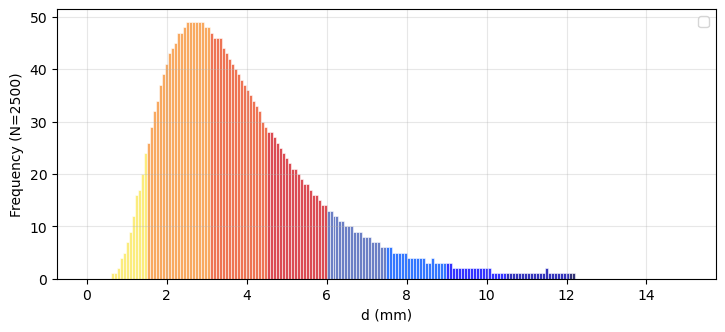

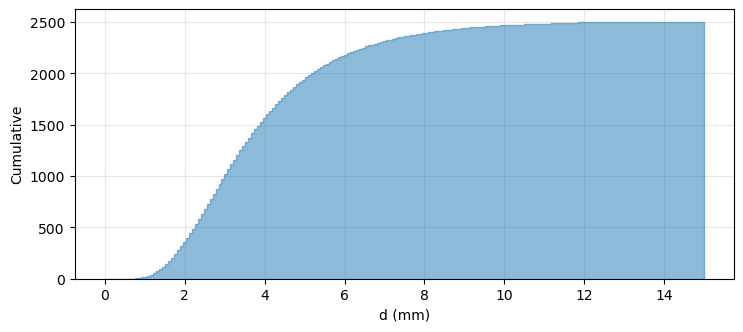

In [19]:
#  PLOTS

plt.clf()  # avoid overplot

# PLOT DISTRIBUTION
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 3.5, forward=True)
plt.grid("both", alpha=0.3)

d1 = d * 1000  # (to mm)
bins1 = bins * 1000  # (to mm)
N, bins, patches = (
    ax.hist(  # N equals f_abs, the number of parcels in each bin, bins are bin edges, patches are rectangulars
        d1, bins=bins1, weights=f_abs, edgecolor="white", linewidth=0.5, alpha=0.8
    )
)


## Create the colormap
colors = [
    tuple(np.array((250, 232, 92)) / 255),  # yellow
    tuple(np.array((245, 106, 41)) / 255),  # orange
    tuple(np.array((211, 31, 40)) / 255),  # red
    # tuple(np.array((73,181,70))/255),   # green
    tuple(np.array((0, 127, 255)) / 255),  # blue
    tuple(np.array((0, 0, 255)) / 255),  # blue
    tuple(np.array((0, 0, 128)) / 255),  # blue
    tuple(np.array((0, 0, 0)) / 255),
]  # black


mycmap = LinearSegmentedColormap.from_list("WhiteBlueGreenYellowRed", colors, N=10)

for b, p in zip(bins1 / max(bins), patches):
    plt.setp(p, "facecolor", mycmap(b))


plt.xlabel("d (mm)", fontsize=10)
plt.ylabel("Frequency (N=" + str(N_particles) + ")", fontsize=10)
d1r = np.round(d1, 1)
# plt.xticks(d1r, fontsize=6 )
# plt.yticks(fontsize=8 )
# plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig("./size_distr_N" + str(N_particles) + ".png", bbox_inches="tight", dpi=300)


# PLOT CUMULATIVE

fig = plt.figure()
fig.set_size_inches(8.5, 3.5, forward=True)
plt.grid("both", alpha=0.3)
# plt.xscale('log')
plt.hist(d1, bins=bins1, weights=cum, histtype="step", fill=True, alpha=0.5)
# plt.xticks(d1, fontsize=4)
# plt.xscale('log')
plt.xlabel("d (mm)")
plt.ylabel("Cumulative")
# plt.show()
plt.savefig("./cumulative" + str(N_particles) + ".png", bbox_inches="tight", dpi=300)

In [21]:
# CALCULATE critical diameter

dc = (
    9.52
    * kin_visc_oil ** (2 / 3)
    * 9.81 ** (-1 / 3)
    * (1 - rho_oil / rho_a) ** (-1 / 3)
)
print("Critical diameter is {} mm".format(dc))

for i in range(0, Nbins):
    if d[i] < dc:
        w[i] = (9.81 * d[i] ** 2 * (1 - rho_oil / rho_a)) / (18 * kin_visc_oil)
    elif d[i] > dc:
        w[i] = (8 / 3 * 9.81 * d[i] * (1 - rho_oil / rho_a)) ** (1 / 2)

Critical diameter is 0.004163740082321075 mm


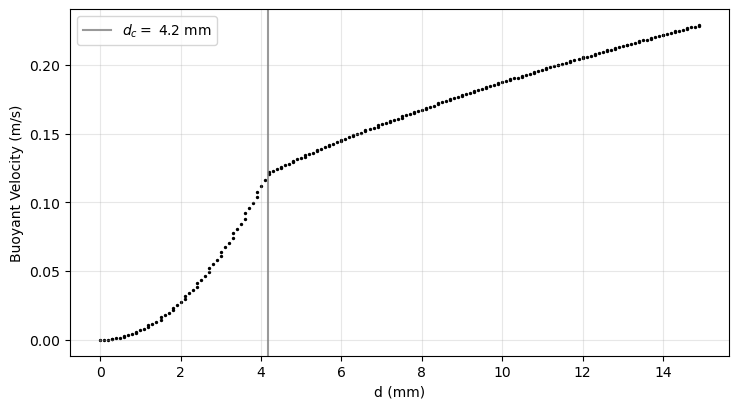

In [22]:
# PLOT VERTICAL BUOYANT VELOCITY


fig = plt.figure()

fig.set_size_inches(8.5, 4.5, forward=True)

plt.grid("both", alpha=0.3)

plt.axvline(
    x=dc * 1000,
    color="gray",
    linestyle="-",
    alpha=0.8,
    label=r"$d_c =$ " + str("%.1f" % (dc * 1000)) + " mm",
)

plt.scatter(d1r, w, color="black", s=2)

# plt.xscale('log')


plt.xlabel("d (mm)", fontsize=10)

# plt.xticks(d1r, fontsize=6 )

# plt.yticks(fontsize=8 )

# plt.xlim([0,15])

plt.ylabel("Buoyant Velocity (m/s)", fontsize=10)
plt.legend()

# plt.show()

plt.savefig("./buoyant_velocities.png", bbox_inches="tight", dpi=300)


# rint('size of fabs:', f_abs.size)

# print('size of w:', w.size)


data = {"Diam (mm)": d * 1000, "w_buoy (m/s)": -w, "Frequency": f}
datafile = pd.DataFrame(data)
datafile.to_csv("w_buoy.csv", index=False, sep="\t", float_format="%.4f")